# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u


## 2. Read data

### select one dataset:

In [2]:
dataset = 2

In [3]:
plots = False

In [4]:
plots = True

Red arm:

In [5]:
if dataset == 1:
    hdu = fits.open('data/v1/supercube_2963102-001.fit')

In [6]:
if dataset == 2:
    hdu = fits.open('data/v2/stackcube_2963102.fit')

In [7]:
hdu.info()
wcs = WCS(hdu[1].header)
wavelength = wcs.spectral.pixel_to_world(np.arange(hdu[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function = hdu[5].data

Filename: data/v2/stackcube_2963102.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     468   ()      
  1  RED_DATA      1 ImageHDU        72   (170, 178, 7341)   float32   
  2  RED_IVAR      1 ImageHDU        72   (170, 178, 7341)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (170, 178, 7341)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (170, 178, 7341)   float32   
  5  RED_SENSFUNC    1 ImageHDU        15   (7341,)   float32   
  6  RED_DATA_COLLAPSE3    1 ImageHDU        72   (170, 178)   float32   
  7  RED_IVAR_COLLAPSE3    1 ImageHDU        72   (170, 178)   float32   


### explore counts to define bright, medium, and faint regions:

In [8]:
mean_counts = np.nanmean(hdu[1].data, axis=0)  # same as hdu[6]
median_counts = np.nanmedian(hdu[1].data, axis=0)

mean_sky_map = np.nanmean(hdu[3].data-hdu[1].data, axis=0)
median_sky_map = np.nanmedian(hdu[3].data-hdu[1].data, axis=0)

mask_bright = mean_counts > mean_sky_map
mask_medium = (median_counts > median_sky_map) & (mean_counts <= mean_sky_map)
mask_faint = (mean_counts > 0) & (median_counts <= median_sky_map)
mask_all = mean_counts > 0

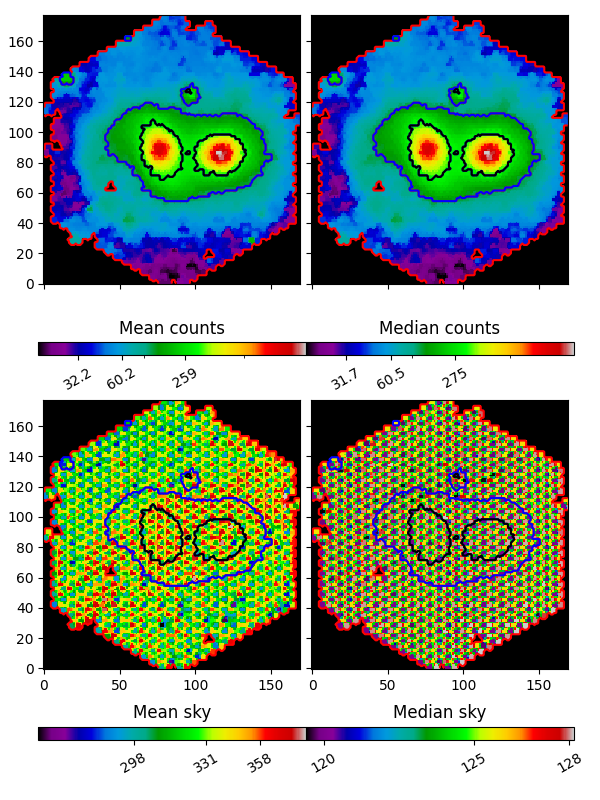

In [9]:
if plots:
    plt.close('counts')
    fig = plt.figure('counts', figsize=(6, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    
    def show_data(data, ax, title):
        p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap='nipy_spectral',
                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)
        
    show_data(mean_counts, ax[0, 0], 'Mean counts')
    show_data(median_counts, ax[0, 1], 'Median counts')
    show_data(mean_sky_map, ax[1, 0], 'Mean sky')
    show_data(median_sky_map, ax[1, 1], 'Median sky')
    
    plt.show()

### average SED within each region:

In [10]:
datacube = hdu[1].data * sensitivity_function[:, np.newaxis, np.newaxis]


In [11]:
datacube = (hdu[3].data - hdu[1].data) * sensitivity_function[:, np.newaxis, np.newaxis]
sky_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
sky_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium)
sky_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
sky_all = np.nansum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)

In [12]:
datacube = hdu[1].data * sensitivity_function[:, np.newaxis, np.newaxis]
SED_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium, )
SED_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)

### broadband colors:

In [13]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

In [14]:
r_map = r_filter.m_AB_cube(wavelength, datacube)
i_map = i_filter.m_AB_cube(wavelength, datacube)
z_map = z_filter.m_AB_cube(wavelength, datacube)

/tmp/ipykernel_59068/409879002.py:18: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(
/tmp/ipykernel_59068/409879002.py:18: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(


/tmp/ipykernel_59068/3006971549.py:30: RuntimeWarning: invalid value encountered in subtract
  show_data(i_map-z_map, ax[1, 0], '(i-z)', cmap, -.04, .14)
/tmp/ipykernel_59068/3006971549.py:31: RuntimeWarning: invalid value encountered in subtract
  show_data(r_map-z_map, ax[1, 1], '(r-z)', cmap, -.7, .5)
/tmp/ipykernel_59068/3006971549.py:32: RuntimeWarning: invalid value encountered in subtract
  show_data(r_map-i_map, ax[1, 2], '(r-i)', cmap, -.7, .5)


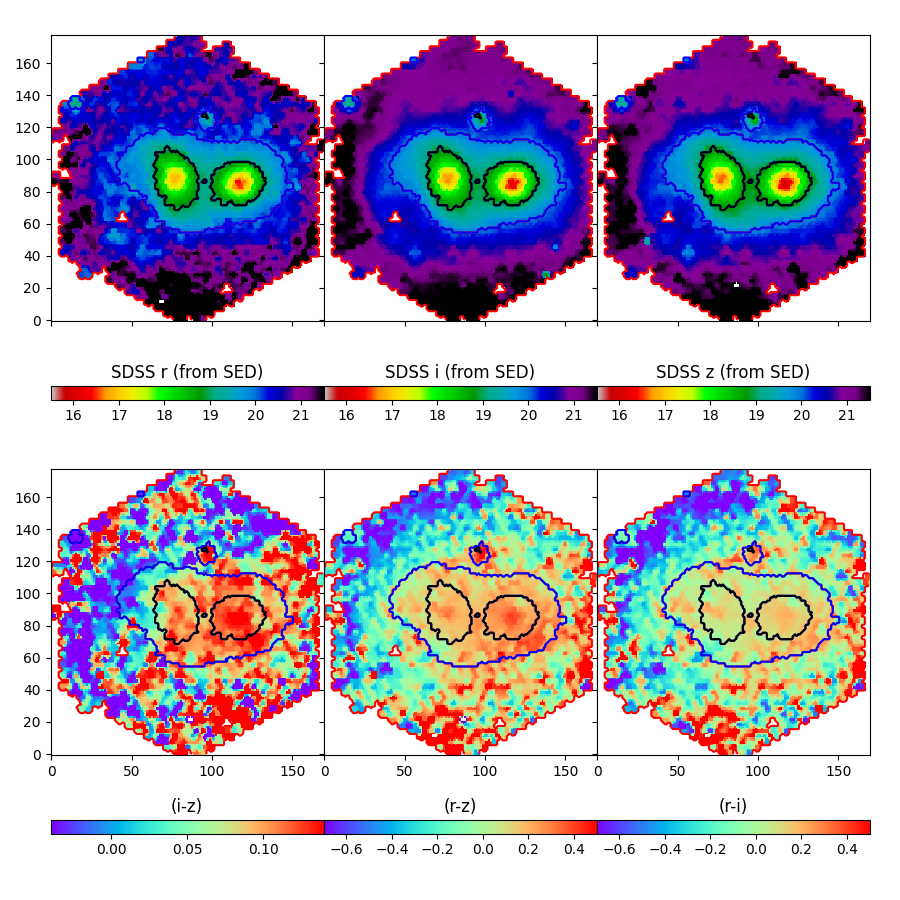

In [15]:
if plots:
    plt.close('broadband')
    fig = plt.figure('broadband', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=3, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    
    def show_data(data, ax, title, cmap, vmin, vmax):
        #p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap=cmap, vmin=vmin, vmax=vmax,
#                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)
        
    cmap = 'nipy_spectral_r'; vmin = 15.5; vmax = 21.5
    show_data(r_map, ax[0, 0], 'SDSS r (from SED)', cmap, vmin, vmax)
    show_data(i_map, ax[0, 1], 'SDSS i (from SED)', cmap, vmin, vmax)
    show_data(z_map, ax[0, 2], 'SDSS z (from SED)', cmap, vmin, vmax)
    cmap = 'rainbow'
    show_data(i_map-z_map, ax[1, 0], '(i-z)', cmap, -.04, .14)
    show_data(r_map-z_map, ax[1, 1], '(r-z)', cmap, -.7, .5)
    show_data(r_map-i_map, ax[1, 2], '(r-i)', cmap, -.7, .5)

    plt.show()

## 3. Spectrophotometric calibration:

In [16]:
r_bright = r_filter.m_AB(wavelength, SED_bright)
i_bright = i_filter.m_AB(wavelength, SED_bright)
z_bright = z_filter.m_AB(wavelength, SED_bright)
r_medium = r_filter.m_AB(wavelength, SED_medium)
i_medium = i_filter.m_AB(wavelength, SED_medium)
z_medium = z_filter.m_AB(wavelength, SED_medium)
r_faint = r_filter.m_AB(wavelength, SED_faint)
i_faint = i_filter.m_AB(wavelength, SED_faint)
z_faint = z_filter.m_AB(wavelength, SED_faint)

In [17]:
lines = {}
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

wavelength_bins = np.array(lines['H_alpha'])
indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


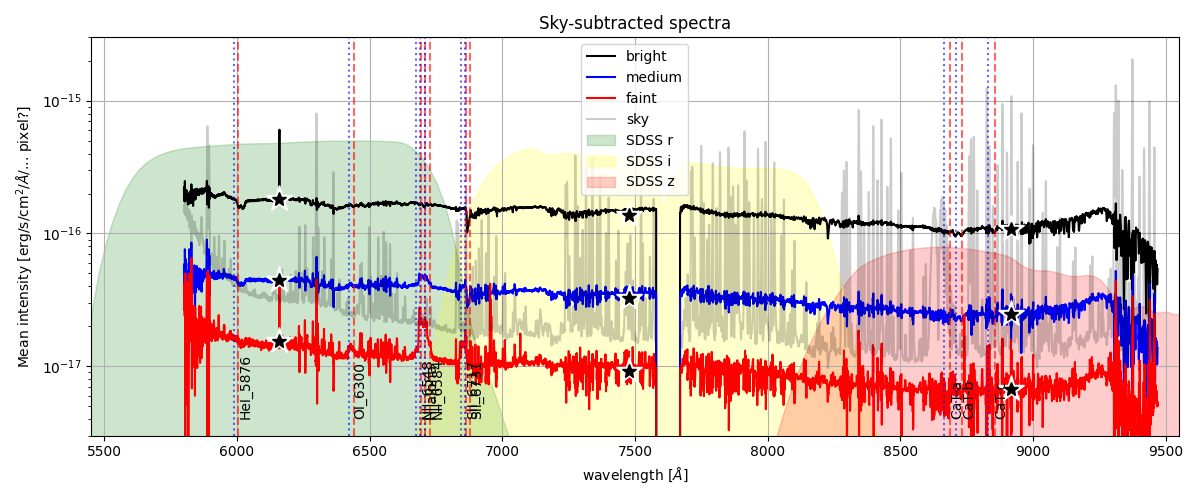

In [18]:
if plots:
    plt.close('spectra')
    fig = plt.figure('spectra', figsize=(12, 5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_title(r'Sky-subtracted spectra')
    ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')
    ax[0, 0].plot(wavelength, SED_bright, 'k-', label='bright')
    ax[0, 0].plot(wavelength, SED_medium, 'b-', label='medium')
    ax[0, 0].plot(wavelength, SED_faint, 'r-', label='faint')
    ax[0, 0].plot(wavelength, sky_all, 'k-', alpha=.2, label='sky')
    ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
    ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
    ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_medium)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_medium)/i_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_medium)/z_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_medium)/r_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_medium)/i_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_medium)/z_filter.pivot_wavelength**2, 'k*', ms=10)
    ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

    ax[0, 0].legend()

    #ax[0, 1].set_title(r'Sky')
    #ax[0, 1].plot(wavelength, sky_bright, c='k', alpha=.2, label='bright')
    #ax[0, 1].plot(wavelength, sky_medium, c='b', alpha=.2, label='medium')
    #ax[0, 1].plot(wavelength, sky_faint, c='r', alpha=.2, label='faint')
    #ax[0, 1].plot(wavelength, sky_all, c='g', alpha=.2, label='all')
    #ax[0, 1].legend()
    
    ax[0, -1].set_yscale('log')
    ax[0, -1].set_ylim(3e-18, 3e-15)
    ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
    ax[-1, -1].set_xlim(5450, 9550)
    #ax[-1, 1].set_xlabel(r'wavelength [$\AA$]')

    for line in lines:
        ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
        ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
        ymin, ymax = ax[0, 0].get_ylim()
        ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
        #print(lines[line][0]*(1+redshift_a), ymin, line)

    ax[0, 0].grid()
    plt.show()

In [19]:
r_bright, r_medium, r_faint

(17.99899385067365, 19.515331640996656, 20.67499094831707)

In [20]:
i_bright, i_medium, i_faint

(17.868807345239144, 19.437753394168066, 20.8059448988578)

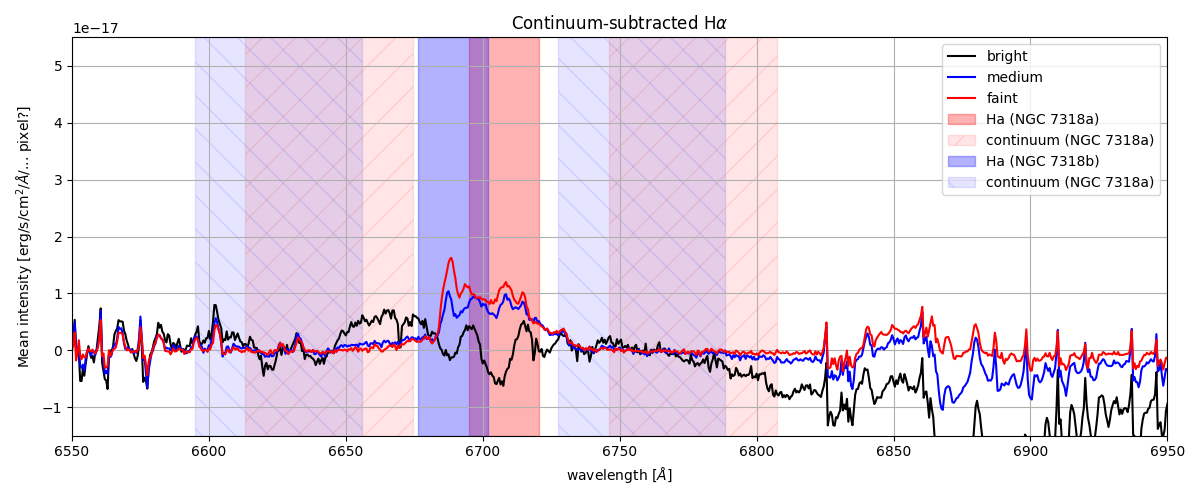

In [21]:
if plots:
    plt.close('H_alpha spectrum')
    fig = plt.figure('H_alpha spectrum', figsize=(12, 5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_title(r'Continuum-subtracted H$\alpha$')
    ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

    blue_side = np.nanmean(SED_bright[indices_Ha_a[3]:indices_Ha_a[4]])
    red_side = np.nanmean(SED_bright[indices_Ha_a[5]:indices_Ha_a[6]])
    central_wavelength = np.mean(wavelength[indices_Ha_a[3:7]])
    slope = (red_side-blue_side)/(wavelength[indices_Ha_a[5]]+ wavelength[indices_Ha_a[6]] -wavelength[indices_Ha_a[3]]-wavelength[indices_Ha_a[4]])
    continuum = (red_side+blue_side)/2 + slope*(wavelength-central_wavelength)
    ax[0, 0].plot(wavelength, SED_bright-continuum, 'k-', label='bright')

    blue_side = np.nanmean(SED_medium[indices_Ha_a[3]:indices_Ha_a[4]])
    red_side = np.nanmean(SED_medium[indices_Ha_a[5]:indices_Ha_a[6]])
    central_wavelength = np.mean(wavelength[indices_Ha_a[3:7]])
    slope = (red_side-blue_side)/(wavelength[indices_Ha_a[5]]+ wavelength[indices_Ha_a[6]] -wavelength[indices_Ha_a[3]]-wavelength[indices_Ha_a[4]])
    continuum = (red_side+blue_side)/2 + slope*(wavelength-central_wavelength)
    ax[0, 0].plot(wavelength, SED_medium-continuum, 'b-', label='medium')

    blue_side = np.nanmean(SED_faint[indices_Ha_a[3]:indices_Ha_a[4]])
    red_side = np.nanmean(SED_faint[indices_Ha_a[5]:indices_Ha_a[6]])
    central_wavelength = np.mean(wavelength[indices_Ha_a[3:7]])
    slope = (red_side-blue_side)/(wavelength[indices_Ha_a[5]]+ wavelength[indices_Ha_a[6]] -wavelength[indices_Ha_a[3]]-wavelength[indices_Ha_a[4]])
    continuum = (red_side+blue_side)/2 + slope*(wavelength-central_wavelength)
    ax[0, 0].plot(wavelength, SED_faint-continuum, 'r-', label='faint')


    #ax[0, -1].set_yscale('log')
    ax[0, -1].set_ylim(-1.5e-17, 5.5e-17)
    ax[0, -1].set_xlim(6550, 6950)
    ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
    #ax[-1, 1].set_xlabel(r'wavelength [$\AA$]')

    ax[0, 0].axvspan(wavelength[indices_Ha_a][1], wavelength[indices_Ha_a][2], color='r', alpha=.3, label='Ha (NGC 7318a)')
    ax[0, 0].axvspan(wavelength[indices_Ha_a][3], wavelength[indices_Ha_a][4], color='r', alpha=.1, hatch='/', label='continuum (NGC 7318a)')
    ax[0, 0].axvspan(wavelength[indices_Ha_a][5], wavelength[indices_Ha_a][6], color='r', alpha=.1, hatch='/')
    ax[0, 0].axvspan(wavelength[indices_Ha_b][1], wavelength[indices_Ha_b][2], color='b', alpha=.3, label='Ha (NGC 7318b)')
    ax[0, 0].axvspan(wavelength[indices_Ha_b][3], wavelength[indices_Ha_b][4], color='b', alpha=.1, hatch='\\', label='continuum (NGC 7318a)')
    ax[0, 0].axvspan(wavelength[indices_Ha_b][5], wavelength[indices_Ha_b][6], color='b', alpha=.1, hatch='\\')

    ax[0, 0].grid()
    ax[0, 0].legend()
    plt.show()

In [22]:
blue_side = np.nanmean(datacube[indices_Ha_a[3]:indices_Ha_a[4], :, :], axis=0)
red_side = np.nanmean(datacube[indices_Ha_a[5]:indices_Ha_a[6], :, :], axis=0)
central_wavelength = np.mean(wavelength[indices_Ha_a[3:7]])
slope = (red_side-blue_side)/(wavelength[indices_Ha_a[5]]+ wavelength[indices_Ha_a[6]] -wavelength[indices_Ha_a[3]]-wavelength[indices_Ha_a[4]])
continuum = (red_side+blue_side)/2 + slope*(lines['H_alpha'][0]-central_wavelength)
Ha_map_a = (np.nanmean(datacube[indices_Ha_a[1]:indices_Ha_a[2], :, :], axis=0)/continuum - 1) * (wavelength[indices_Ha_a[2]] - wavelength[indices_Ha_a[1]])

/tmp/ipykernel_59068/801166132.py:6: RuntimeWarning: invalid value encountered in true_divide
  Ha_map_a = (np.nanmean(datacube[indices_Ha_a[1]:indices_Ha_a[2], :, :], axis=0)/continuum - 1) * (wavelength[indices_Ha_a[2]] - wavelength[indices_Ha_a[1]])


In [23]:
blue_side = np.nanmean(datacube[indices_Ha_b[3]:indices_Ha_b[4], :, :], axis=0)
red_side = np.nanmean(datacube[indices_Ha_b[5]:indices_Ha_b[6], :, :], axis=0)
central_wavelength = np.mean(wavelength[indices_Ha_b[3:7]])
slope = (red_side-blue_side)/(wavelength[indices_Ha_b[5]]+ wavelength[indices_Ha_b[6]] -wavelength[indices_Ha_b[3]]-wavelength[indices_Ha_b[4]])
continuum = (red_side+blue_side)/2 + slope*(lines['H_alpha'][0]-central_wavelength)
Ha_map_b = (np.nanmean(datacube[indices_Ha_b[1]:indices_Ha_b[2], :, :], axis=0)/continuum - 1) * (wavelength[indices_Ha_b[2]] - wavelength[indices_Ha_b[1]])

/tmp/ipykernel_59068/1271537475.py:6: RuntimeWarning: invalid value encountered in true_divide
  Ha_map_b = (np.nanmean(datacube[indices_Ha_b[1]:indices_Ha_b[2], :, :], axis=0)/continuum - 1) * (wavelength[indices_Ha_b[2]] - wavelength[indices_Ha_b[1]])


In [24]:
indices_Ha_a, indices_Ha_b
Ha_map = np.nanmean(datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :], axis=0)
blue_side = np.nanmean(datacube[indices_Ha_b[3]:indices_Ha_b[4], :, :], axis=0)
red_side = np.nanmean(datacube[indices_Ha_a[5]:indices_Ha_a[6], :, :], axis=0)
continuum = (red_side+blue_side)/2
Ha_map = (Ha_map - continuum) * (wavelength[indices_Ha_a[2]] - wavelength[indices_Ha_b[1]])
EW_Ha_map = Ha_map/continuum

/tmp/ipykernel_59068/3998879302.py:7: RuntimeWarning: invalid value encountered in true_divide
  EW_Ha_map = Ha_map/continuum


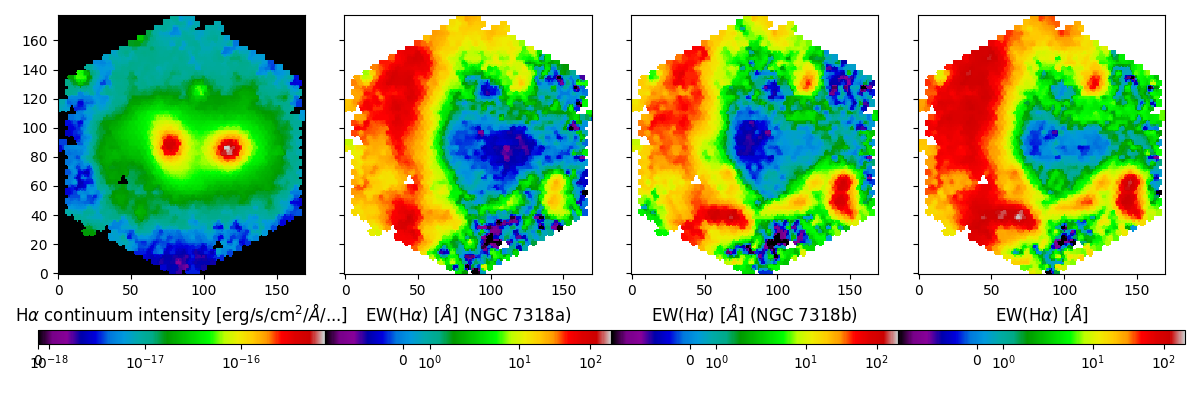

In [25]:
if plots:
    plt.close('H_alpha EW_map')
    fig = plt.figure('H_alpha EW_map', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=4, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    def show_data(data, ax, title, norm):
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap='nipy_spectral', norm=norm,
                      )
        #ax.contour(mask_faint, levels=[0.5], colors=['r'])
        #ax.contour(mask_medium, levels=[0.5], colors=['b'])
        #ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

    p0, p10, p50, p90, p100 = np.nanpercentile(continuum, [0, 10, 50, 90, 100])
    norm = colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0)
    show_data(continuum, ax[0, 0], r'H$\alpha$ continuum intensity [erg/s/cm$^2/\AA$/...]', norm)

    norm = colors.SymLogNorm(vmin=-3, vmax=200, linthresh=3)
    show_data(Ha_map_a, ax[0, 1], r'EW(H$\alpha$) [$\AA$] (NGC 7318a)', norm)
    show_data(Ha_map_b, ax[0, 2], r'EW(H$\alpha$) [$\AA$] (NGC 7318b)', norm)
    show_data(EW_Ha_map, ax[0, 3], r'EW(H$\alpha$) [$\AA$]', norm)

    plt.show()

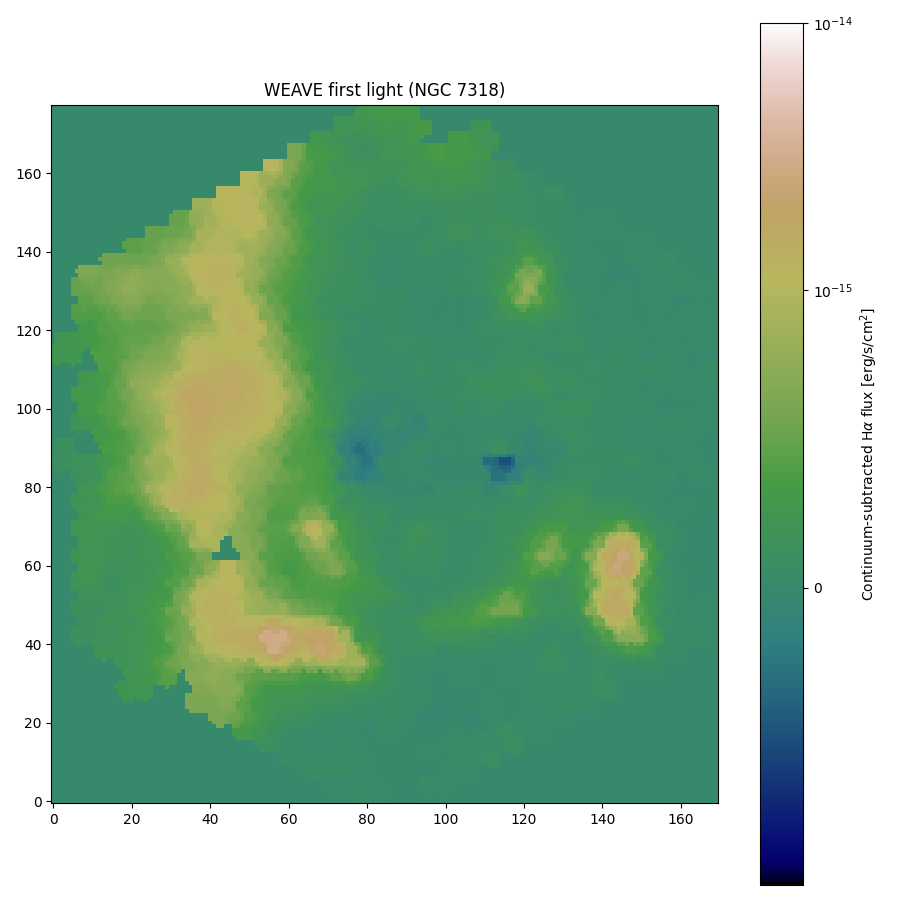

In [26]:
if plots:
    plt.close('H_alpha map')
    fig = plt.figure('H_alpha map', figsize=(9, 9))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    def show_data(data, ax, title):
        p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       #cmap='terrain',
                       cmap='gist_earth',
                       #cmap='inferno',
                       #cmap='nipy_spectral_r',
                       #vmin=-1e-15, vmax=5.5e-15,
                       norm=colors.SymLogNorm(vmin=-1e-15, vmax=1e-14, linthresh=1e-15),
                       #norm=colors.LogNorm(vmin=p0, vmax=p100),
                       #norm=colors.LogNorm(vmin=1e-17, vmax=5e-15),
                      )
        cb = fig.colorbar(im, ax=ax, orientation='vertical')
        #cb.ax.set_title(title)
        ax.set_title('WEAVE first light (NGC 7318)')
        cb.ax.set_ylabel(r'Continuum-subtracted H$\alpha$ flux [erg/s/cm$^2$]')
        cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

    show_data(Ha_map, ax[0, 0], r'EW(H$\alpha$) [$\AA$] (NGC 7318a)')

    plt.savefig('H_alpha.pdf')
    plt.savefig('H_alpha.png')
    plt.show()

/tmp/ipykernel_59068/1829298467.py:13: RuntimeWarning: invalid value encountered in subtract
  ax[0, 0].scatter((i_map-z_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)
/tmp/ipykernel_59068/1829298467.py:14: RuntimeWarning: invalid value encountered in subtract
  ax[0, 1].scatter((r_map-z_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)
/tmp/ipykernel_59068/1829298467.py:15: RuntimeWarning: invalid value encountered in subtract
  ax[0, 2].scatter((r_map-i_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)
/tmp/ipykernel_59068/1829298467.py:18: RuntimeWarning: invalid value encountered in subtract
  ax[1, 0].scatter((i_map-z_map).ravel(), Ha_map_b.ravel(), s=1, alpha=.1)
/tmp/ipykernel_59068/1829298467.py:19: RuntimeWarning: invalid value encountered in subtract
  ax[1, 1].scatter((r_map-z_map).ravel(), Ha_map_b.ravel(), s=1, alpha=.1)
/tmp/ipykernel_59068/1829298467.py:20: RuntimeWarning: invalid value encountered in subtract
  ax[1, 2].scatter((r_map-i_map).ravel(), Ha_map_b.ravel(), s=1, al

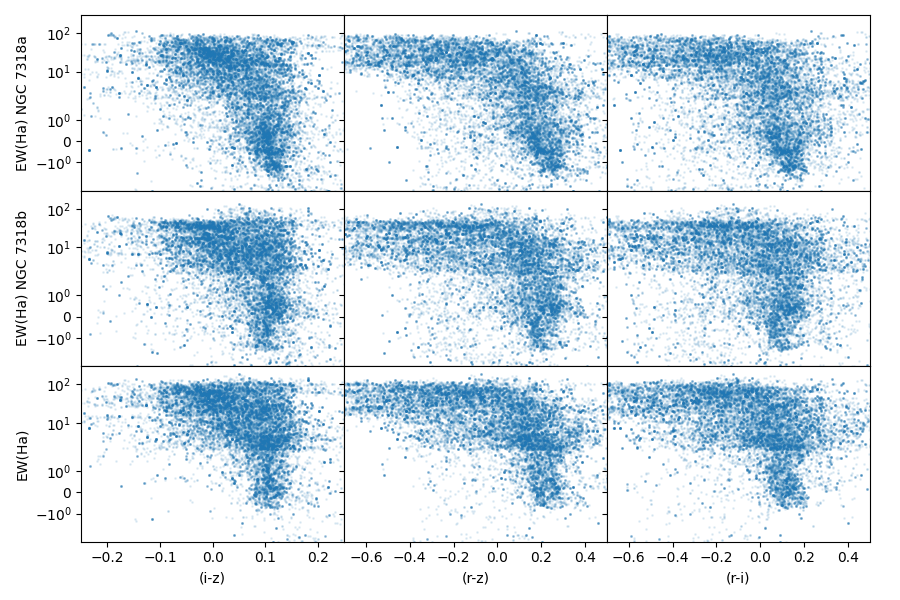

In [27]:
if plots:
    plt.close('ageing')
    fig = plt.figure('ageing', figsize=(9, 6))
    ax = fig.subplots(nrows=3, ncols=3, squeeze=False,
                      sharex='col', sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel('EW(Ha) NGC 7318a')
    ax[0, 0].set_yscale('symlog')
    ax[0, 0].set_ylim(-3, 300)
    ax[0, 0].scatter((i_map-z_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)
    ax[0, 1].scatter((r_map-z_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)
    ax[0, 2].scatter((r_map-i_map).ravel(), Ha_map_a.ravel(), s=1, alpha=.1)

    ax[1, 0].set_ylabel('EW(Ha) NGC 7318b')
    ax[1, 0].scatter((i_map-z_map).ravel(), Ha_map_b.ravel(), s=1, alpha=.1)
    ax[1, 1].scatter((r_map-z_map).ravel(), Ha_map_b.ravel(), s=1, alpha=.1)
    ax[1, 2].scatter((r_map-i_map).ravel(), Ha_map_b.ravel(), s=1, alpha=.1)

    ax[2, 0].set_ylabel('EW(Ha)')
    ax[2, 0].scatter((i_map-z_map).ravel(), EW_Ha_map.ravel(), s=1, alpha=.1)
    ax[2, 1].scatter((r_map-z_map).ravel(), EW_Ha_map.ravel(), s=1, alpha=.1)
    ax[2, 2].scatter((r_map-i_map).ravel(), EW_Ha_map.ravel(), s=1, alpha=.1)

    ax[-1, 0].set_xlabel('(i-z)'); ax[-1, 0].set_xlim(-.25,  .25)
    ax[-1, 1].set_xlabel('(r-z)'); ax[-1, 1].set_xlim(-.7,  .5)
    ax[-1, 2].set_xlabel('(r-i)'); ax[-1, 2].set_xlim(-.7,  .5)
    plt.show()
